# Running NA-MD calculations with Model Hamiltonians in Libra


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Model Hamiltonians](#2)

3. [Choosing the Nonadiabatic Dynamics Methodology](#3)

4. [Choosing initial conditions: Nuclear and Electronic](#4)

5. [Running the calculations](#5)

6. [Plotting the results](#6)

7. [The corresponding SOFT calculations](#7)



## A. Learning objectives

- to be analize various model Hamiltonians available in Libra's database


## B. Use cases

- [Plot 1D PES](#)


## C. Functions

- `libra_py`
  - `dynamics_plotting`
    - [`plot_surfaces`](#plot_surfaces-1) | [or here](#plot_surfaces-2) | [or here](#plot_surfaces-3) | [or here](#plot_surfaces-4)
  - `dynamics`
    - `exact`
      - `compute`
        - [`init_wfc`](#init_wfc-1)
        - [`run_dynamics`](#run_dynamics-1)
      - `save`
        - [`init_tsh_savers`](#init_tsh_savers-1)        
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic_recipe-1)
      - `plot`
        - [`plot_dynamics`](#plot_dynamics-1)        
  - `models`     
     - `Holstein`
       - [`Holstein2`](#Holstein2-1)
       

## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package

In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
import libra_py.models.Morse as Morse
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot

import libra_py.dynamics.exact.compute as dvr
import libra_py.dynamics.exact.save as dvr_save

import libra_py.data_savers as data_savers


#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 2. Model Hamiltonians
<a name="2"></a>[Back to TOC](#TOC)

First, let's define the `compute_model` function that returns all the necessary objects and properties for the dynamics. The `potential` function is used later in the DVR calculations
<a name="Holstein2-1"></a>

In [ ]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = Holstein.Holstein2(q, params, full_id) 
    elif model==2:
        pass #res = compute_model_nbra(q, params, full_id)
    elif model==3:
        pass #res = compute_model_nbra_files(q, params, full_id)        
    elif model==4:
        res = Morse.general(q, params, full_id)    

    return res

def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

Define several sets of parameters for Holstein Hamiltonian. In this case, we work with a simple system of 2 diabatic surfaces (parabolas) coupled by a constant coupling. 

In [6]:
model_params1 = {"model":1, "model0":1, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.000, "nstates":2}
model_params2 = {"model":1, "model0":1, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.001, "nstates":2}
model_params3 = {"model":1, "model0":1, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.01, "nstates":2}
model_params4 = {"model":1, "model0":1, "E_n":[0.0, -0.01], "x_n":[0.0,  0.5],"k_n":[0.002, 0.008],"V":0.001, "nstates":2}

all_model_params = [model_params1, model_params2, model_params3, model_params4]

Let's explore these 4 models. 

First, let's set up some general parameters for plotting. Note these ones, especially:

* `save_figures:0` - we are not saving the resulting figures; otherwise, we'd need to have the output folder defined by `prefix` created first. If the folder doesn't exist and you try saving figures, you'll get an error. 
* `do_show:1` - this is the option to show the plots in the Jupyter notebook. This is useful when you are using the notebook. However, if you run a plain Python version of this code, you may want to turn this option off. Othwewise, you may need to close bunch of pop-up windows (with the plots) before the script can proceed. In that case, better use the `save_figures` option.
* `plotting_option:1` - see the explanation below:

   - when set to `0` - Plot diabatic and adiabatic surfaces separately, plot projections too
   
   - when set to `1` - Plot diabatic and adiabatic surfaces in one picture, using dashed lines for diabatic. Plot NACs in a separate panel
* `nac_idof:0` - index of the nuclear DOF for which the derivative coupling is computed

In [7]:
# New plotting:
# Common setups
plot_params = {"figsize":[24, 6], "titlesize":24, "labelsize":28, "fontsize": 28, "xticksize":26, "yticksize":26,
               "colors": colors, "clrs_index": clrs_index,
               "prefix":F"case", "save_figures":0, "do_show":1,
               "plotting_option":1, "nac_idof":0 }


The first model, **Model 1** has zero diabatic coupling, so this is the trivial crossing model - the diabatic surfaces do not interact, so the adiabatic surfaces are simply the lower- and upper-energy values of these curves. The NACs is zero everywhere, but it should be infinity at the exact crossing point.

The parameters are as follows:
* `xlim` - the range of x values for which the surfaces are plotted (the range of the x values for which the surfaces are computed is setup in the `plot_surface` function below) 
* `ylim` - the range of energy values for which the surfaces are plotted (left panel)
* `ylim2` - the range of NAC values for which the surfaces are plotted (right panel)
<a name="plot_surfaces-1"></a>

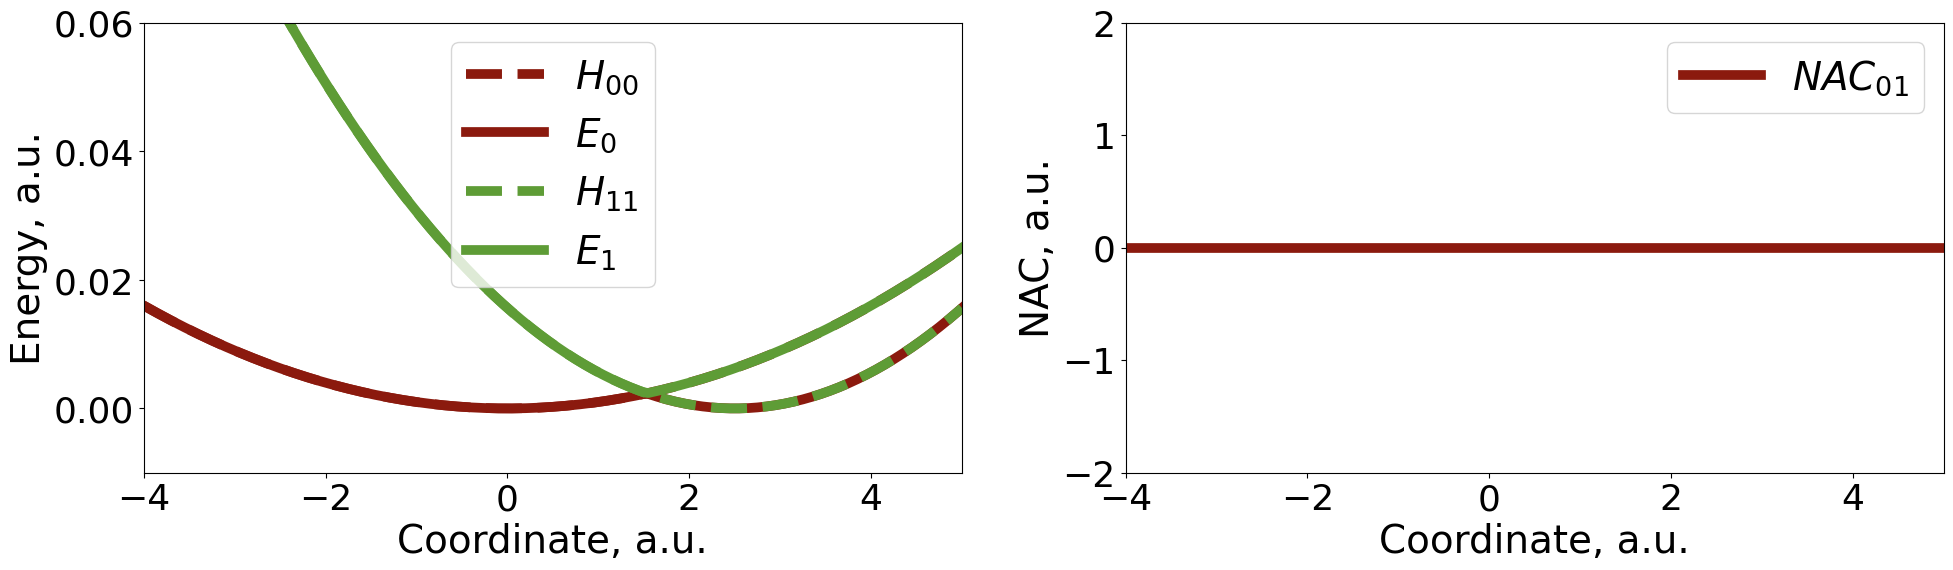

In [8]:
# Model 1
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01, 0.06], "ylim2":[-2, 2], "show_nac_abs":0 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params1 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

The next model, **Model 2** adds a non-zero and rather small diabatic coupling, so that the surfaces do interact, but the splitting between the adiabatic surfaces is small, hence large NAC 
<a name="plot_surfaces-2"></a>

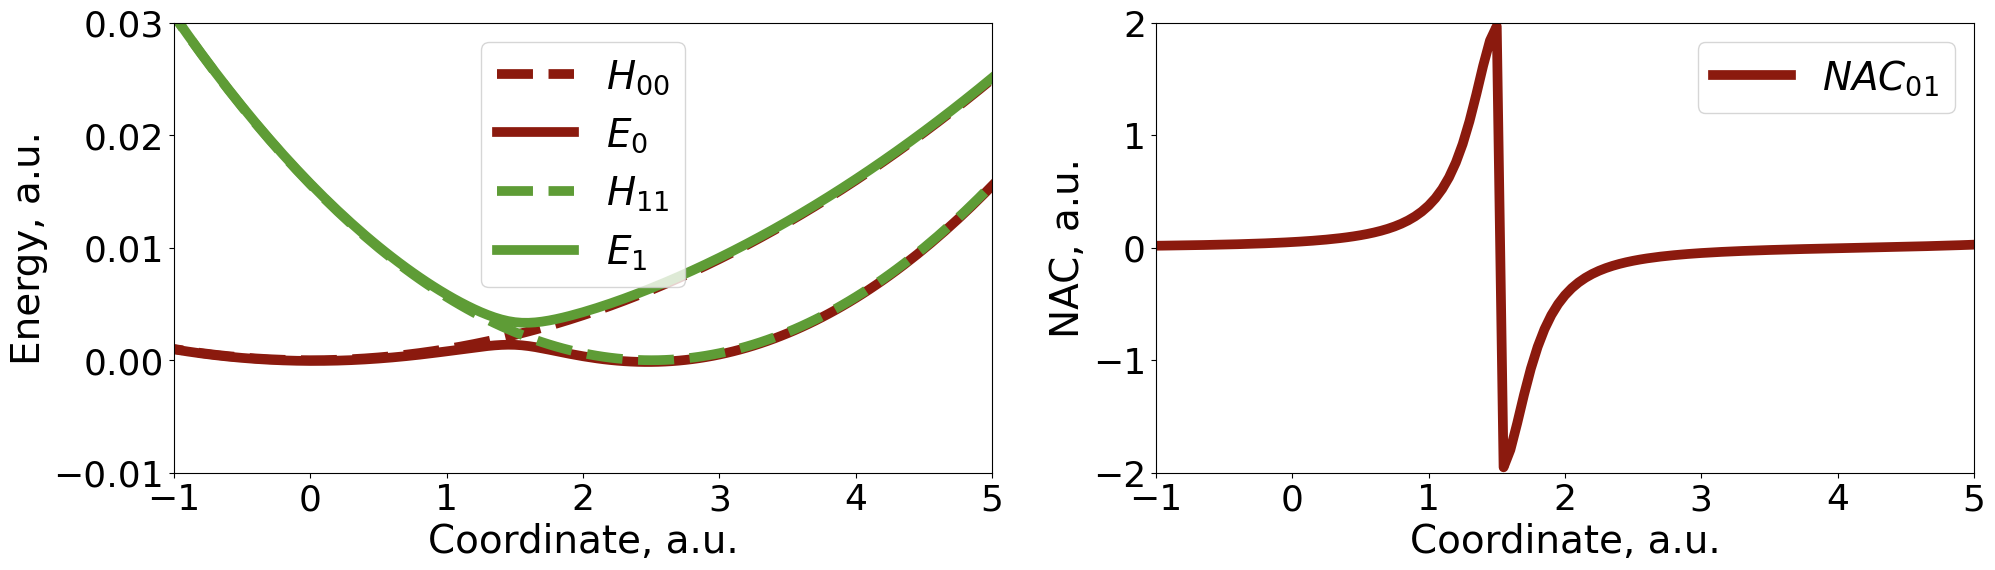

In [9]:
# Model 2
plot_params.update( { "xlim":[-1, 5], "ylim":[-0.01, 0.03], "ylim2":[-2, 2], "show_nac_abs":0 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params2 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

Note that the NACs as computed have the sign flipped when coordinate passes the crossing point. This is because the order of the adiabatic states is switched in this scan (we don't track how the surfaces should actually follow in a continuous way). The correct way the NACs should appear is the Lorentzian shape. To show it, we can simply show the absolute values of NACs. This can be done with the following setup:

`show_nac_abs:1` - this also adds plotting of NAC absolute values (green dash) on top of the NAC values (red solid lines)
<a name="plot_surfaces-3"></a>

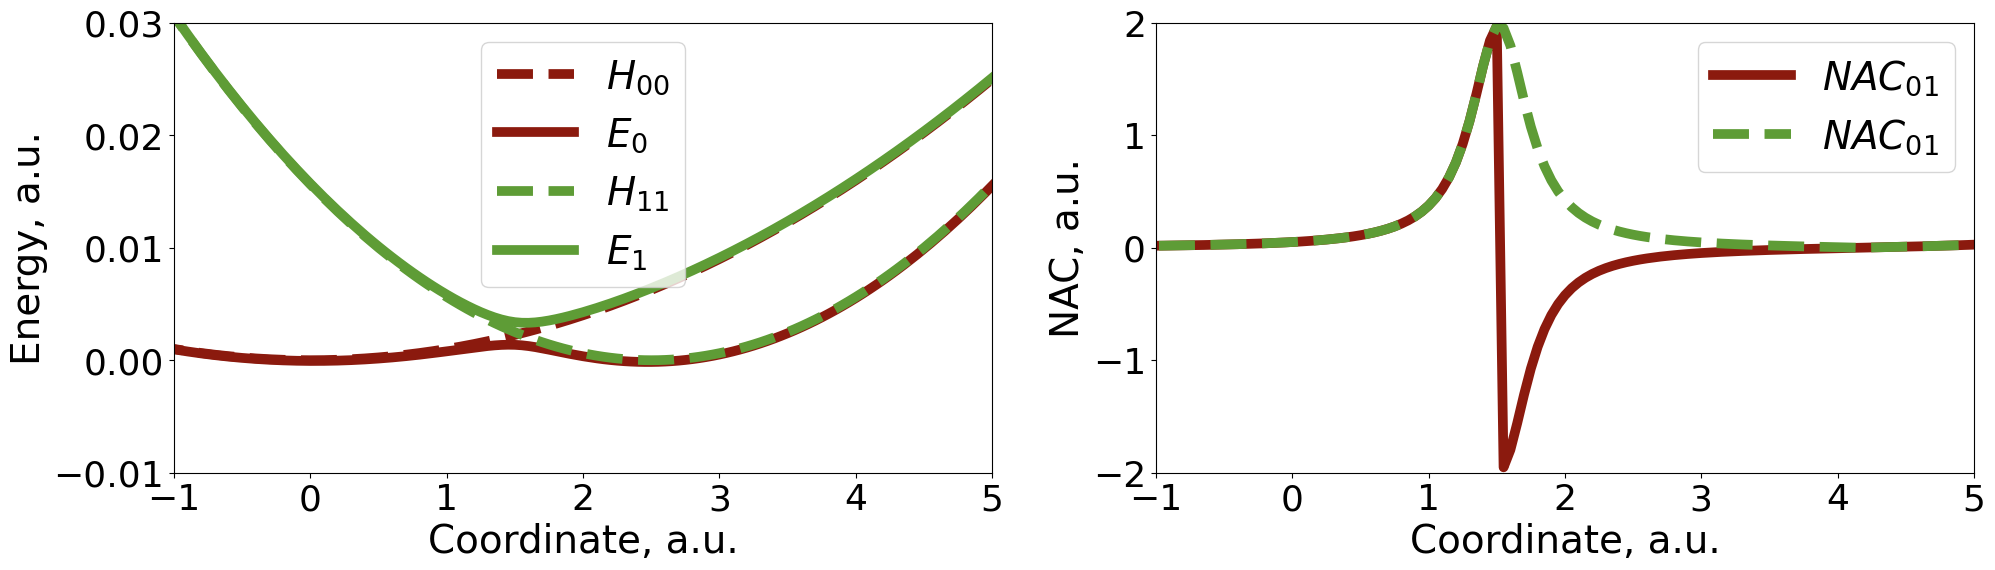

In [10]:
# Special plot for discussion of the NAC sign change
plot_params.update( { "xlim":[-1, 5], "ylim":[-0.01, 0.03], "ylim2":[-2, 2], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params2 ], [0, 1], -4.0, 5.0, 0.05, plot_params)


In the next model, **Model 3**, we use even larger diabatic coupling, so that the adiabatic surfaces have a large gap between them. In this case, the NACs are small, so the nonadiabatic effects are rather low - this is a model for primarily adiabatic dynamics.
<a name="plot_surfaces-4"></a>

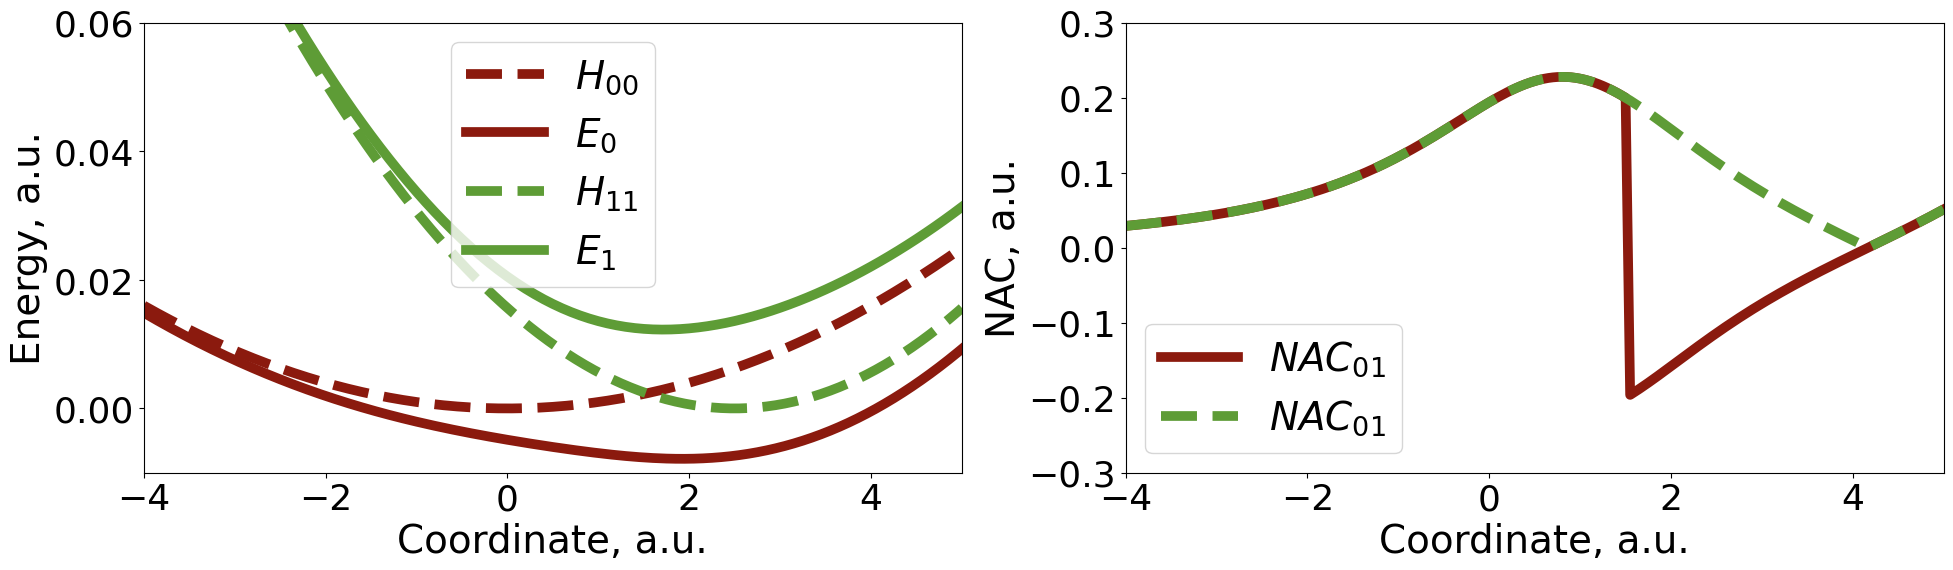

In [11]:
# Model 3
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01, 0.06], "ylim2":[-0.3, 0.3],"show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params3 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

Finally, the **Model 4** is a more compicated case of Model 2. The parabolas are shifted and their curvatures are chosen such that we have two crossing regions. Then, we have the two regions of strong nonadiabatic coupling

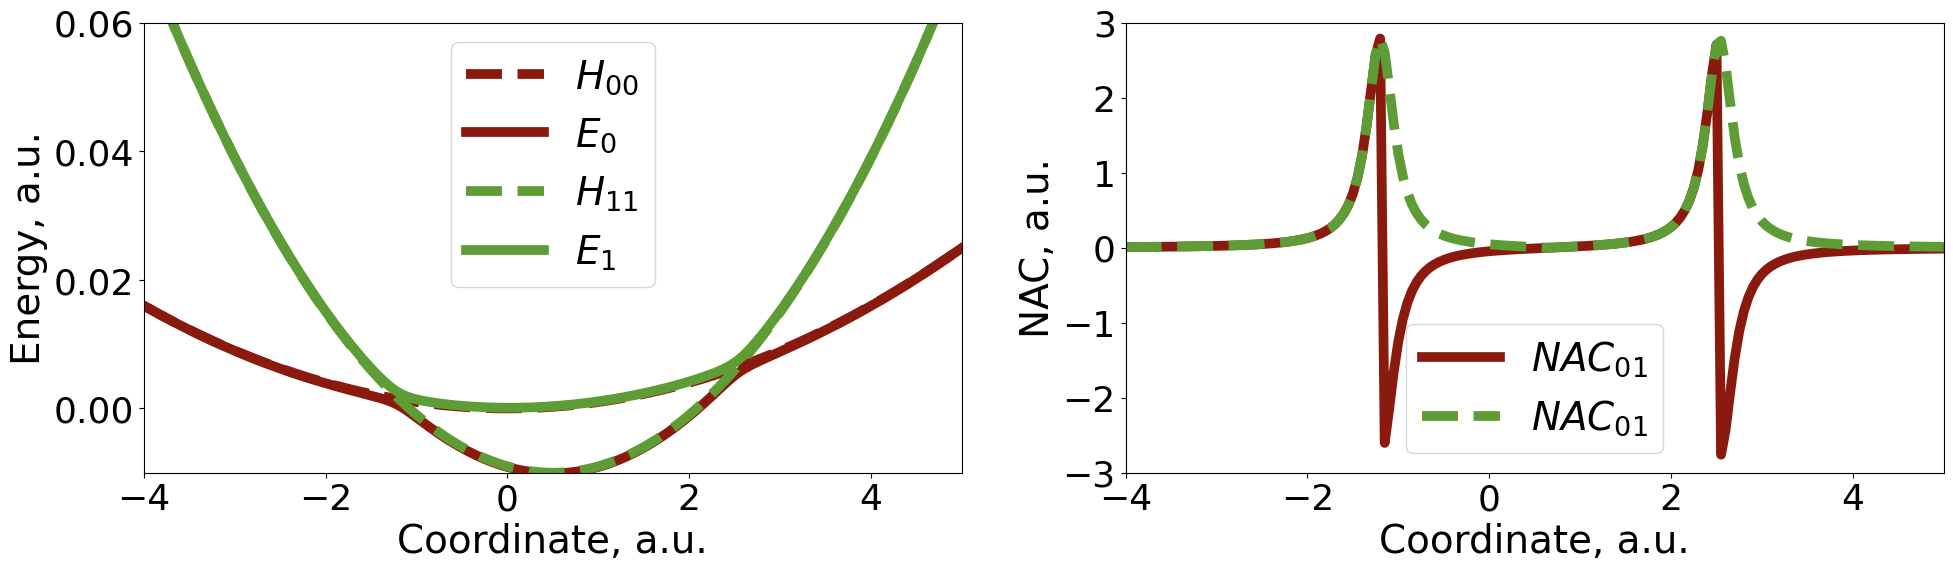

In [12]:
# Model 4
plot_params.update( { "xlim":[-4, 5], "ylim":[-0.01, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params4 ], [0, 1], -4.0, 5.0, 0.05, plot_params)

So select the model

In [13]:
#################################
# Give the model used an index
model_indx = 1
model_params = all_model_params[model_indx]
#################################

## 3. Choosing the Nonadiabatic Dynamics Methodology 
<a name="3"></a>[Back to TOC](#TOC)

In this section, we go over parameters to set up a computational methodology. 

Let's start with the simulation-specific parameters:

* `nsteps` -  how many steps of dynamics to compute
* `nstaj` - how many trajectories to use
* `nstates:2` - all our models are 2-level systems
* `dt:10` - nuclear integration timestep in a.u. of time
* `num_electronic_substeps` - do multiple steps of electronic integration per nuclear step
* `isNBRA` and `is_nbra` - is set to `1`, will turn on some simplifications and optimization for NBRA type of calculations. Here, we are doing the non-NBRA case
* `frogress_frequency:0.1` - printing out a message evry `2500 x 0.1 = 250` steps
* `which_adi_states` - properties of which adiabatic states to save, we only have 2
* `which_dia_states` - properties of which diabatic states to save, we only have 2
* `mem_output_level:4` - how much data to save into the hdf5 output files. This is the most intensive output, usually needed only for some special cases (extra-analysis, debugging, new methods, demonstration like htis, etc.)
* `properties_to_save` - list of properties to be computed on the fly and saved into hdf5 output file.

In [14]:
dyn_general = { "nsteps":2500, "ntraj":25, "nstates":2,
                "dt":10.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(2), "which_dia_states":range(2),      
                "mem_output_level":4,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "se_pop_adi", "se_pop_dia", "sh_pop_adi", "hvib_adi", "hvib_dia", "St", "basis_transform", "D_adi" ],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }

Now, it is time to select the type of calculations we want to do. Keep in mind that some options are related to each other, so usually one would need to correlate the choices

In [15]:
# Uncomment one of the options in each of the categories below:
#====== How to update Hamiltonian ===================
#dyn_general.update({"ham_update_method":0}) # don't update any Hamiltonians
dyn_general.update({"ham_update_method":1})  # recompute only diabatic Hamiltonian, common choice for model Hamiltonians 
#dyn_general.update({"ham_update_method":2})  # recompute only adiabatic Hamiltonian; use with file-based or on-the-fly workflows


#====== How to transform the Hamiltonians between representations ============
#dyn_general.update( {"ham_transform_method":0 }) # don't do any transforms; usually for NBRA or on-the-fly workflows, 
                                                 # so you don't override the read values
dyn_general.update( {"ham_transform_method":1 }) # diabatic->adiabatic according to internal diagonalization
#dyn_general.update( {"ham_transform_method":2 }) # diabatic->adiabatic according to internally stored basis transformation matrix
#dyn_general.update( {"ham_transform_method":3 }) # adiabatic->diabatic according to internally stored basis transformation matrix
#dyn_general.update( {"ham_transform_method":4 }) # adiabatic->diabatic according to local diabatization method

#====== How do get the time-overlaps in the dynamics ========
#dyn_general.update( {"time_overlap_method":0 })  # don't update time-overlaps - maybe they are already pre-computed and read
dyn_general.update( {"time_overlap_method":1 }) # explicitly compute it from the wavefunction info; common for model Hamiltonians

#================== How to compute NACs ===============================
dyn_general.update({"nac_update_method":1})  # explicit NAC calculations - let's just focus on this one for now
#dyn_general.update({"nac_update_method":2, "nac_algo":0})  # HST algo
#dyn_general.update({"nac_update_method":2, "nac_algo":1})  # NPI algo

#============== How to compute vibronic Hamiltonian ==============
#dyn_general.update( {"hvib_update_method":0 }) # don't update Hvib; maybe because we read it from files
dyn_general.update( {"hvib_update_method":1 }) # recompute diabatic and adiabatic Hvib from the Ham and NACs in those reps

#=========== Ehrenfest or state-resolved options ===========
# This is what we use with any of the TSH-based methods - in all cases here, we would 
# use "rep_force":1 so that we are guided by the forces derived from the adiabatic surfaces.
# In Ehrenfest cases though, the forces can be computed using only diabatic properties though 
dyn_general.update( {"force_method":1, "rep_force":1} ) # state-resolved (e.g. TSH) with adiabatic forces
#dyn_general.update( {"force_method":2, "rep_force":1} ) # for Ehrenfest in adiabatic rep
#dyn_general.update( {"force_method":2, "rep_force":0} ) # for Ehrenfest in diabatic rep


#============ Types of surface hopping acceptance and momenta rescaling opntions =================
#dyn_general.update({"hop_acceptance_algo":10, "momenta_rescaling_algo":100 })  # accept and rescale based on total energy, do not reverse on frustrated
dyn_general.update({"hop_acceptance_algo":10, "momenta_rescaling_algo":101 })  # accept and rescale based on total energy, reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":20, "momenta_rescaling_algo":200 })  # accept and rescale based on NAC vectors, do not reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":20, "momenta_rescaling_algo":201 })  # accept and rescale based on NAC vectors, reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":21, "momenta_rescaling_algo":200 })  # accept and rescale based on force differences, do not reverse on frustrated
#dyn_general.update({"hop_acceptance_algo":21, "momenta_rescaling_algo":201 })  # accept and rescale based on force differences, reverse on frustrated


#============ Surface hopping opntions =================
#dyn_general.update({"tsh_method":-1 }) # adiabatic, no surface hopping
dyn_general.update({"tsh_method":0 }) # FSSH
#dyn_general.update({"tsh_method":1 }) # GFSH
#dyn_general.update({"tsh_method":2 }) # MSSH
#dyn_general.update({"tsh_method":3, "rep_lz":0 })  # LZ options
#dyn_general.update({"tsh_method":4, "rep_lz":0 }) # ZN
#dyn_general.update({"tsh_method":5 }) # DISH

#=========== Decoherence options =================
dyn_general.update({ "decoherence_algo":-1}) # no (additional) decoherence
#dyn_general.update({ "decoherence_algo":0}) # msdm  
#dyn_general.update({ "decoherence_algo":1}) # IDA
#dyn_general.update({ "decoherence_algo":2}) # A-FSSH, not yet ready
#dyn_general.update({ "decoherence_algo":3}) # BCSH
#dyn_general.update({ "decoherence_algo":4}) # mfsd

#=========== Decoherence times (for decoherence options 0 or 4) ==================
A = MATRIX(2,2); A.set(0, 0, 10.0); A.set(1,1, 10.0)
dyn_general.update({"decoherence_times_type":-1 }) # No decoherence times, infinite decoherence times
#dyn_general.update( { "decoherence_times_type":1, "decoherence_C_param": 1.0, "decoherence_eps_param":0.1 } )  # EDC + default params
#dyn_general.update( { "decoherence_times_type":2, "schwartz_decoherence_inv_alpha":A } ) # Schwartz version 1
#dyn_general.update( { "decoherence_times_type":3, "schwartz_decoherence_inv_alpha":A } ) # Schwartz version 2

#======= Various decoherence-related parameters =====================
dyn_general.update( {"dephasing_informed":0, "decoherence_rates":MATRIX(2,2), "ave_gaps":MATRIX(2,2) } )
                               
#=========== Phase correction of SSY =================
dyn_general.update({"do_ssy":0 }) # do no use it - that's the default

#=========== What to integrate ==================
# solve TD-SE in diabatic representation
#dyn_general.update({"rep_tdse":0, "electronic_integrator":-1 })   # no propagation
#dyn_general.update({"rep_tdse":0, "electronic_integrator":0 })    # Lowdin exp_ with 2-point Hvib_dia
#dyn_general.update({"rep_tdse":0, "electronic_integrator":1 })    # based on QTAG propagator
#dyn_general.update({"rep_tdse":0, "electronic_integrator":2 })    # based on modified QTAG propagator (Z at two times)
#dyn_general.update({"rep_tdse":0, "electronic_integrator":3 })    # non-Hermitian integrator with 2-point Hvib_dia

# solve TD-SE in adiabatic representation
#dyn_general.update({"rep_tdse":1, "electronic_integrator":-1 })  # no propagation
#dyn_general.update({"rep_tdse":1, "electronic_integrator":0 })   # ld, with crude splitting,  with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":1 })   # ld, with symmetric splitting, with exp_
dyn_general.update({"rep_tdse":1, "electronic_integrator":2 })   # ld, original, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":3 })   # 1-point, Hvib integration, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":4 })   # 2-points, Hvib integration, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":5 })   # 2-points, Hvib, integration with the second-point correction of Hvib, with exp_
#dyn_general.update({"rep_tdse":1, "electronic_integrator":6 })   # same as 4, but without projection matrices (T_new = I)
#dyn_general.update({"rep_tdse":1, "electronic_integrator":10 })  # same as 0, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":11 })  # same as 1, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":12 })  # same as 2, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":13 })  # same as 3, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":14 })  # same as 4, but with rotations
#dyn_general.update({"rep_tdse":1, "electronic_integrator":15 })  # same as 5, but with rotations

# solve QCLE in diabatic representation
#dyn_general.update({"rep_tdse":3, "electronic_integrator":0 })  # mid-point Hvib, using exp_

# solve QCLE in adiabatic representation
#dyn_general.update({"rep_tdse":3, "electronic_integrator":0 })  # mid-point Ham with the second-point correction of Hvib, using exp_
#dyn_general.update({"rep_tdse":3, "electronic_integrator":1 })  # using Zhu Liouvillian THIS IS NOT JUST A DIFFERENT INTEGRATOR!!!!
#dyn_general.update({"rep_tdse":3, "electronic_integrator":10 }) # same as 0 but with rotations


#################################
# Give the recipe above an index
method_indx = 0
#################################


## 4. Choosing initial conditions: Nuclear and Electronic
<a name="4"></a>[Back to TOC](#TOC)

The setup of the parameters below is rather intuitive:

* `ndof` - number of nuclear degrees of freedom
* `q` - nuclear coordinates, should be of length `ndof`
* `p` - nuclear momenta, should be of length `ndof`
* `mass` - nuclear masses, should be of length `ndof`
* `force_constant` - should be of length `ndof`; this is the force constant of the harmonic potential that defines the width of the Gaussian wavepacket (that is the ground-state solution for such potential)
* `init_type` - how to sample (or not) momenta and coordinates

For electronic variables:
* `ndia` - the number of diabatic states
* `nadi` - the number of adiabatic states
* `rep` - representation in which we initialize the electronic variables:
  - 0 - diabatic wfc;
  - 1 - adiabatic wfc;
  - 2 - diabatic density matrix;
  - 3 - adiabatic density matrix;
* `istates` - the populations of all `rep` states, should be of length `nadi`
* `init_type` - how to sample amplitudes

In [16]:
#============== How nuclear DOFs are initialized =================
#icond_nucl = 0  # Coords and momenta are set exactly to the given value
#icond_nucl = 1  # Coords are set, momenta are sampled
#icond_nucl = 2  # Coords are sampled, momenta are set
icond_nucl = 3  # Both coords and momenta are samples

nucl_params = { "ndof":1, "q":[-4.0], "p":[0.0], 
                "mass":[2000.0], "force_constant":[0.01], 
                "init_type":icond_nucl }

#============= How electronic DOFs are initialized ==================
#icond_elec = 2  # amplitudes all have the same phase
icond_elec = 3  # amplitudes gain random phase 

#============= Also select the representation ========================
# rep = 0 # diabatic wfc
rep = 1 # adiabatic wfc

elec_params = {"verbosity":2, "init_dm_type":0,
               "ndia":2, "nadi":2, 
               "rep":rep, "init_type":icond_elec, "istates":[1.0, 0.0]
              }


#============== This computes the enumerated index of the initial condition =============
icond_indx = rep * 8 + (icond_elec-2)*4 + icond_nucl


## 5. Running the calculations
<a name="5"></a>[Back to TOC](#TOC)
<a name="generic_recipe-1"></a>

In [17]:
%%time

dyn_params = dict(dyn_general)
dyn_params.update({ "prefix":F"model{model_indx}-method{method_indx}-icond{icond_indx}", 
                    "prefix2":F"model{model_indx}-method{method_indx}-icond{icond_indx}" })

print(F"Computing model{model_indx}-method{method_indx}-icond{icond_indx}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)

Computing model1-method0-icond15
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
s

 step= 250
 step= 500
 step= 750
 step= 1000
 step= 1250
 step= 1500
 step= 1750
 step= 2000
 step= 2250
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'D_adi']
keywords =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'D_adi']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi', 'D_adi', 'q', 'p', 'f', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform'])
Saving the dataset named timestep/data
Saving the dataset named time/data
Saving the dataset named q/data
Saving the dataset named p/data
Saving the dataset named f/data
Saving the dataset named Cadi/data
Saving the dataset named Cdia/data
Saving the dataset nam

## 6. Plotting the results
<a name="6"></a>[Back to TOC](#TOC)
<a name="plot_dynamics-1"></a>

metersUse the default value 
In cctor: lvl = 1 der_lvl = 2
WARN

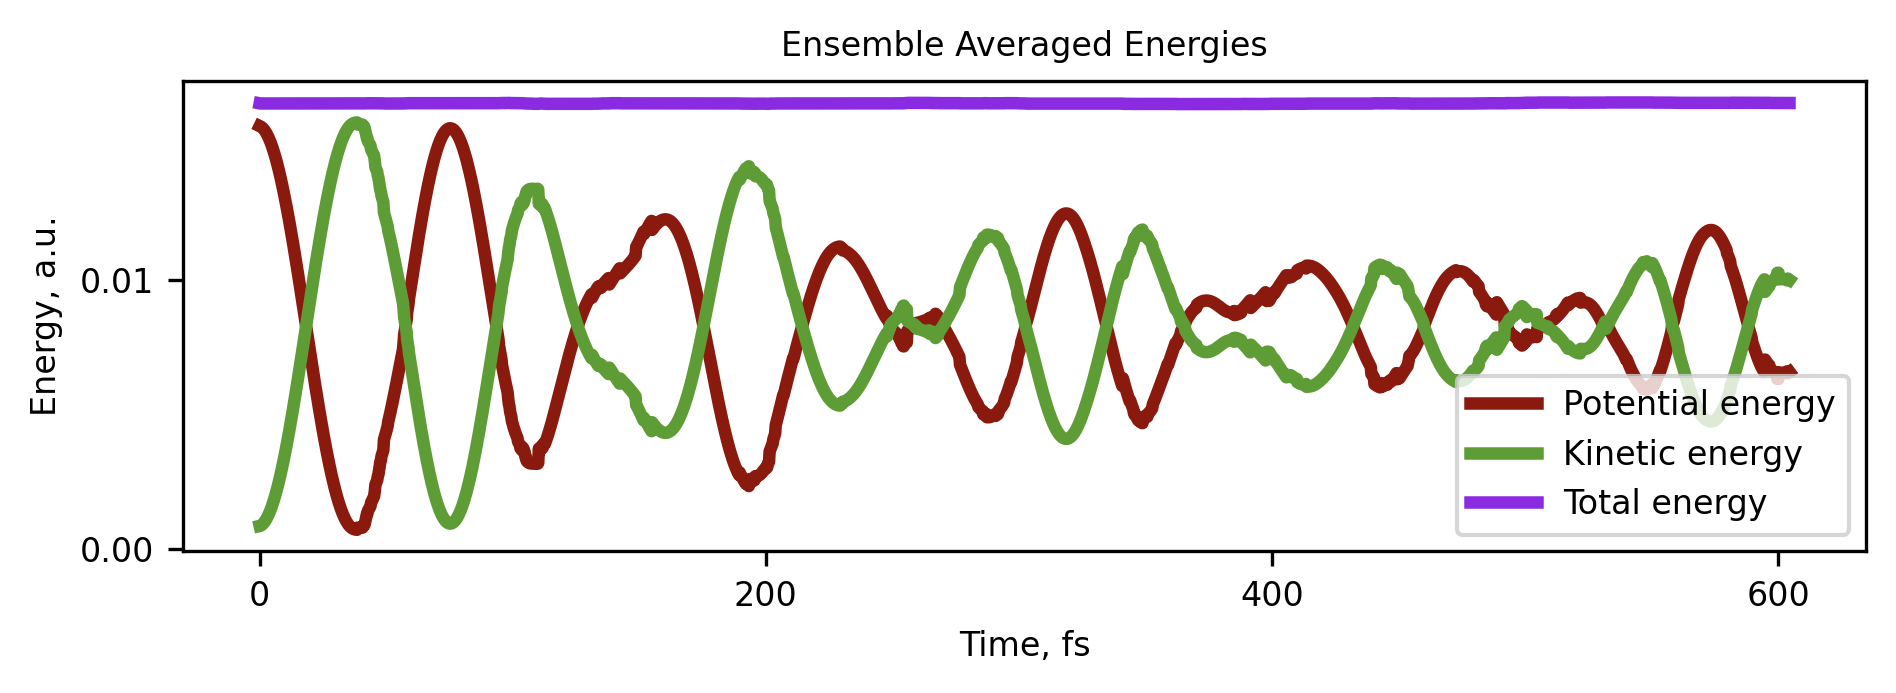

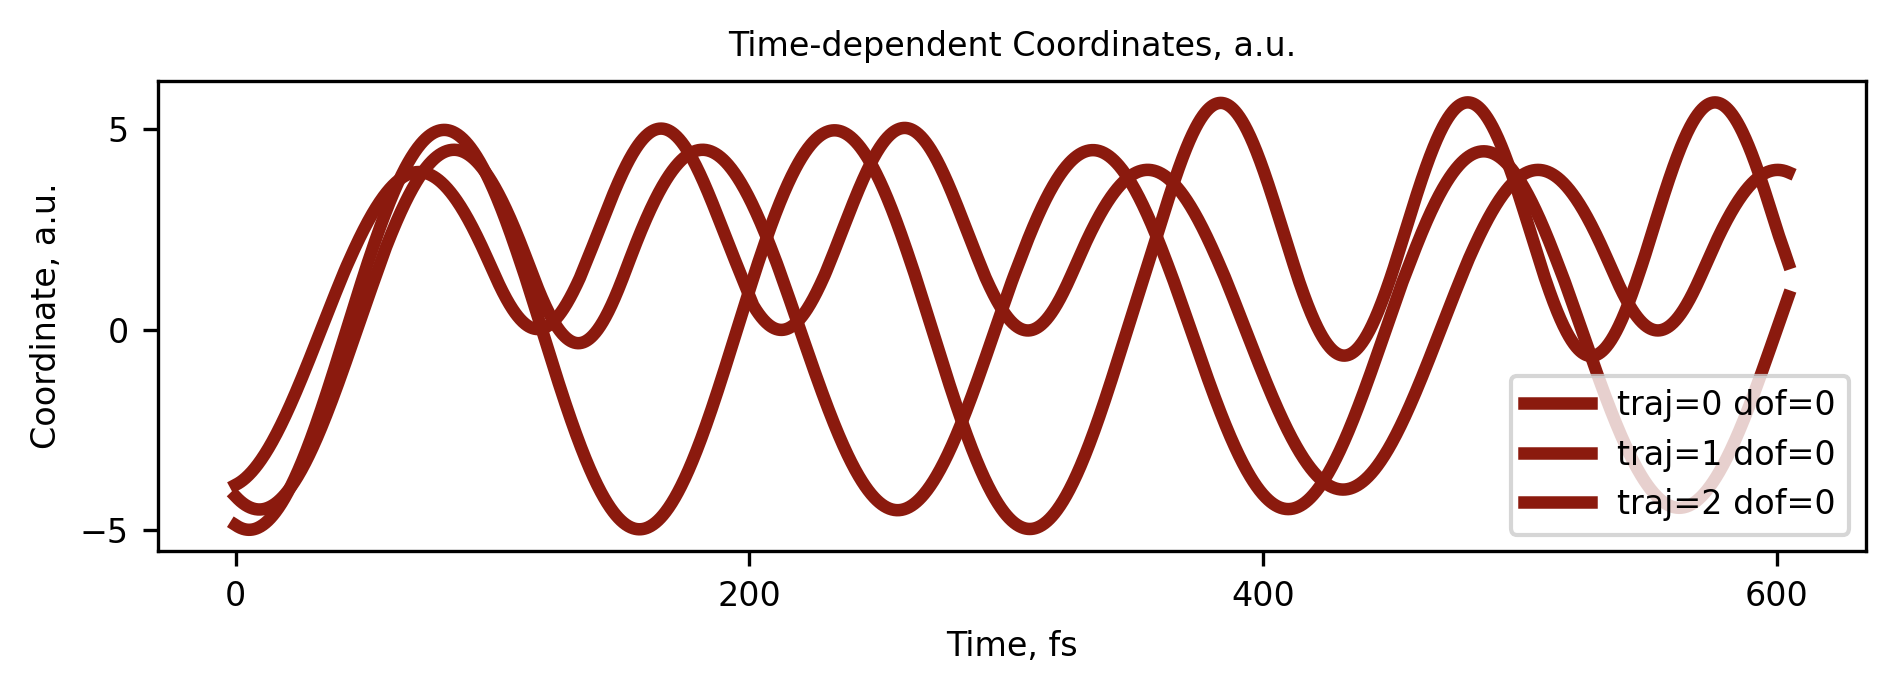

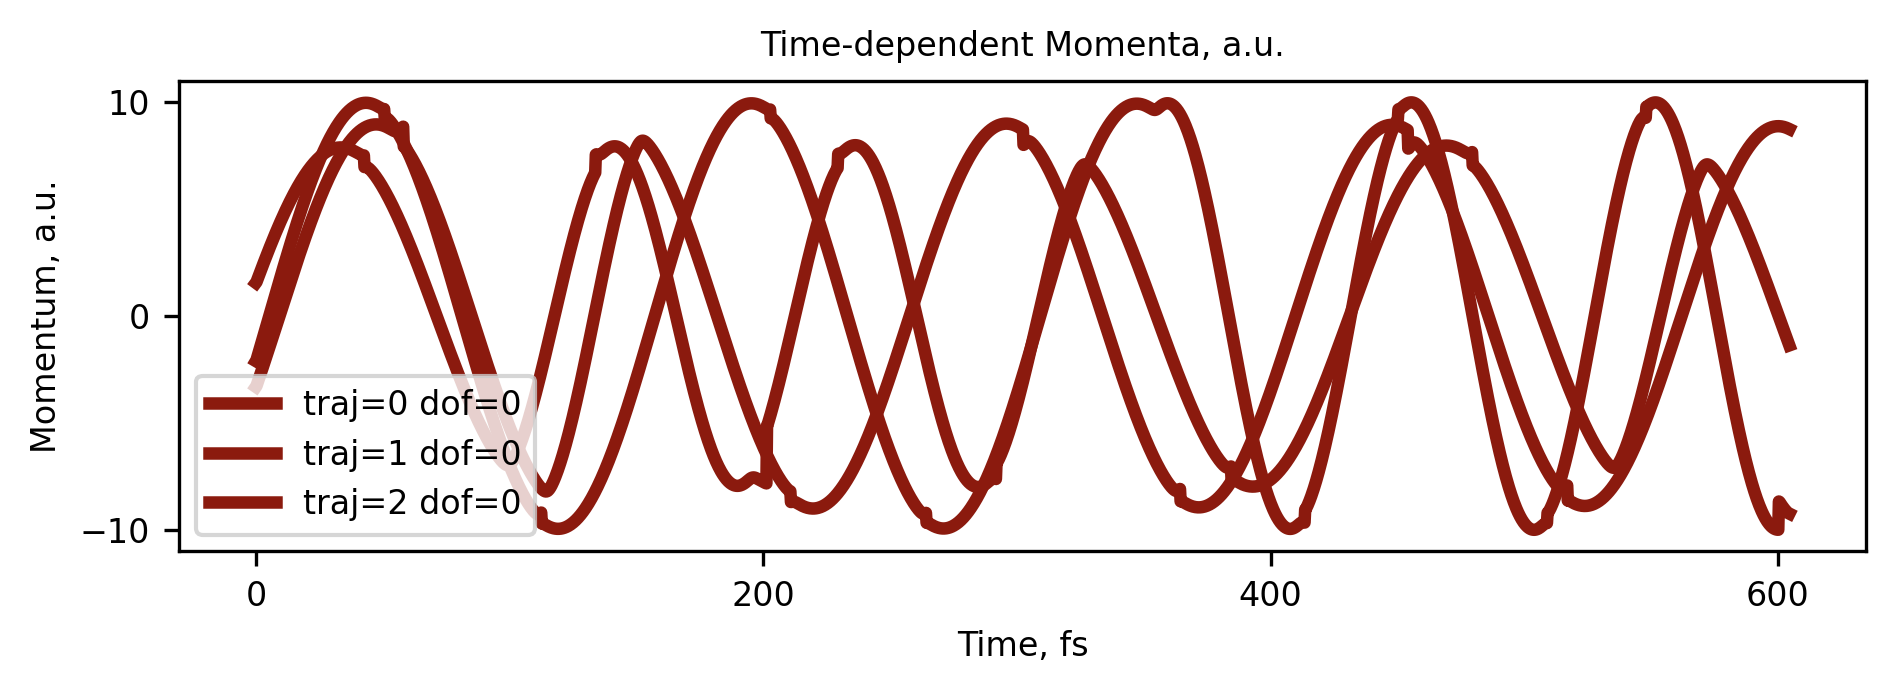

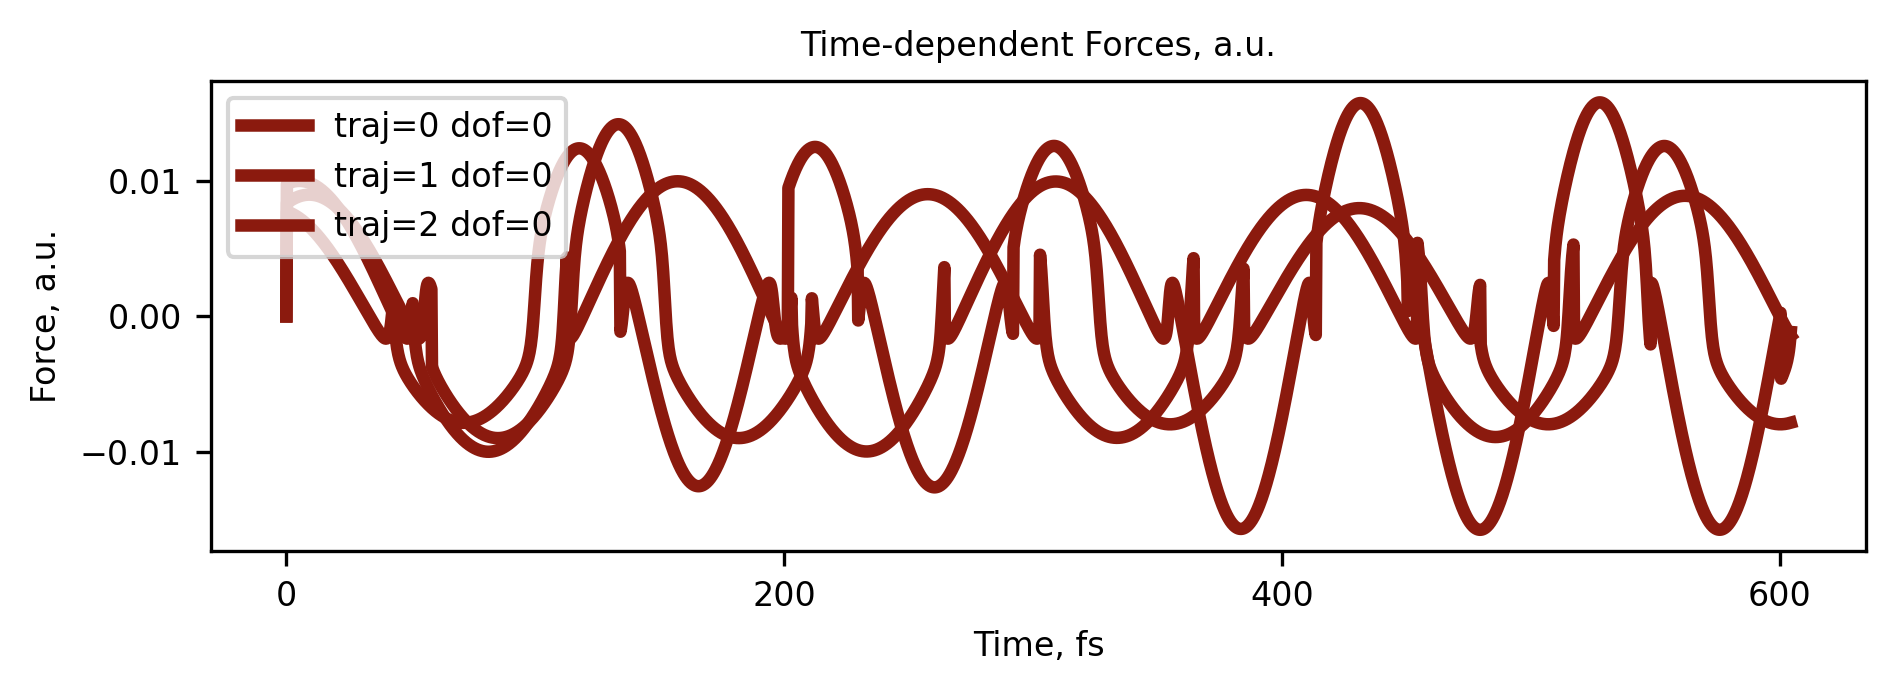

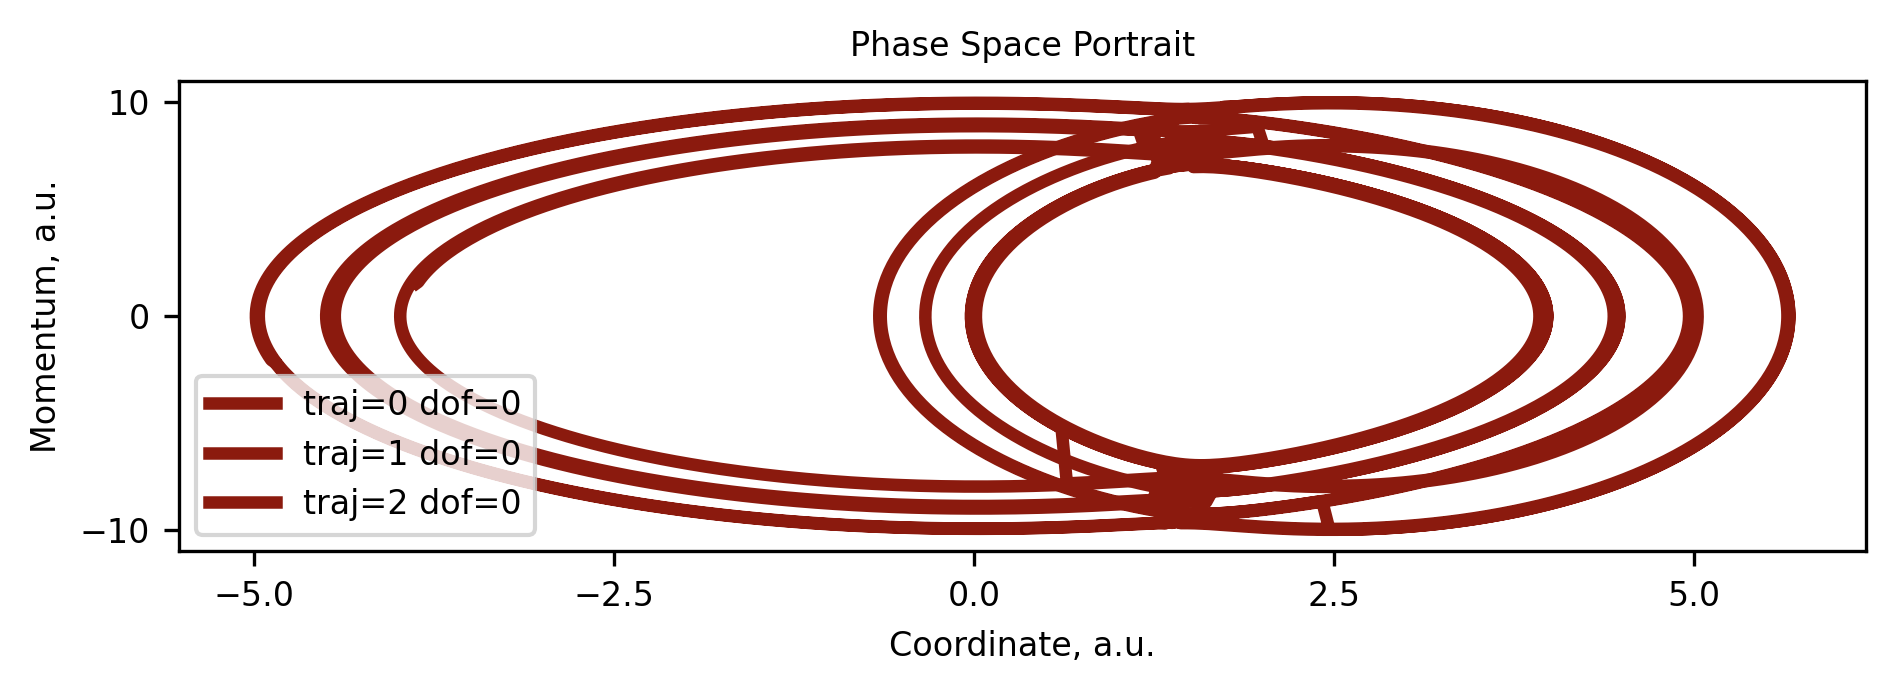

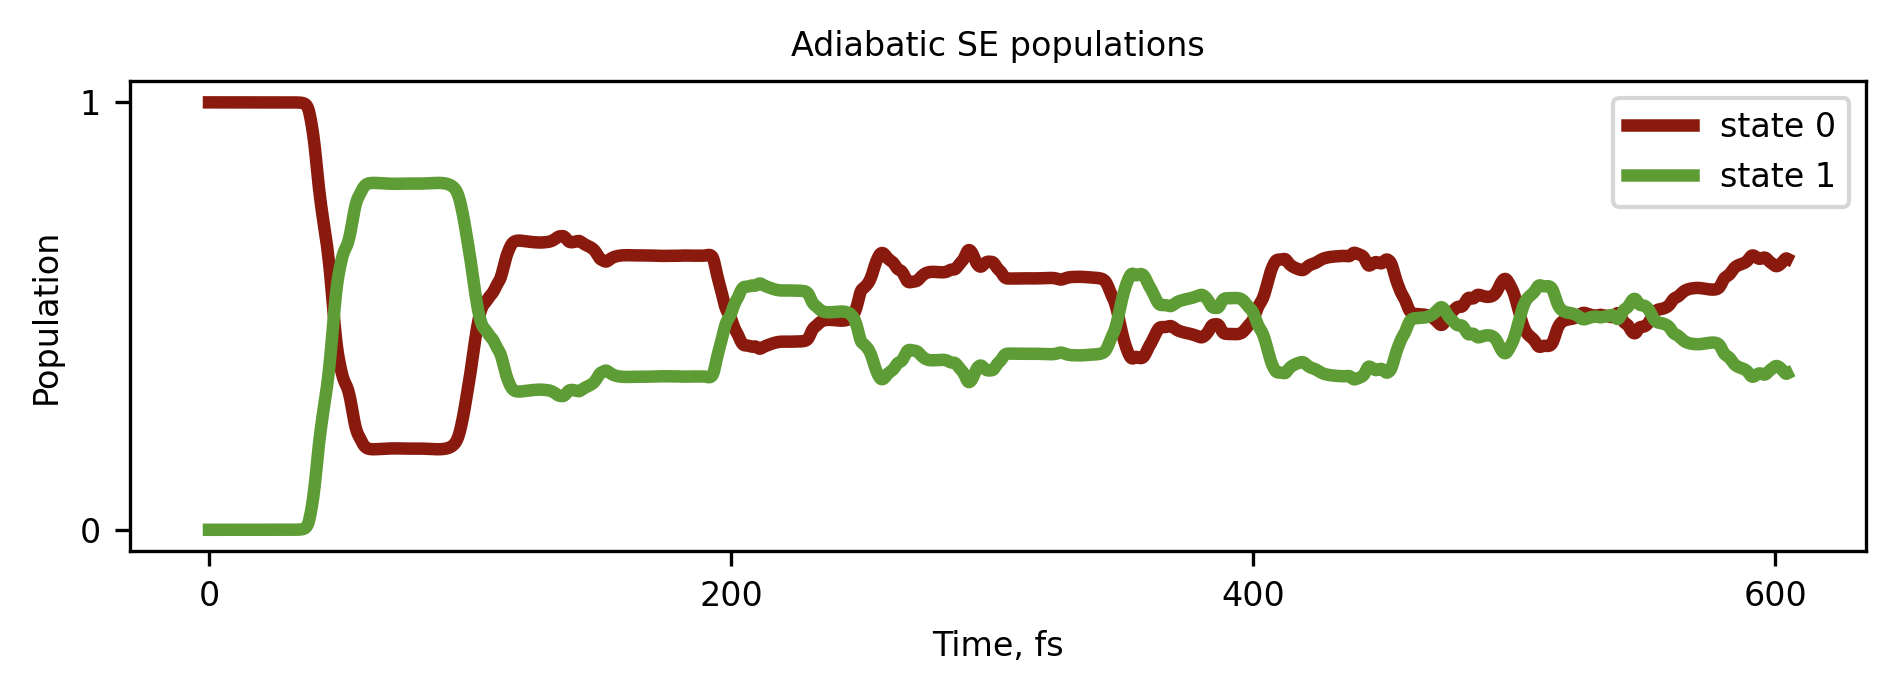

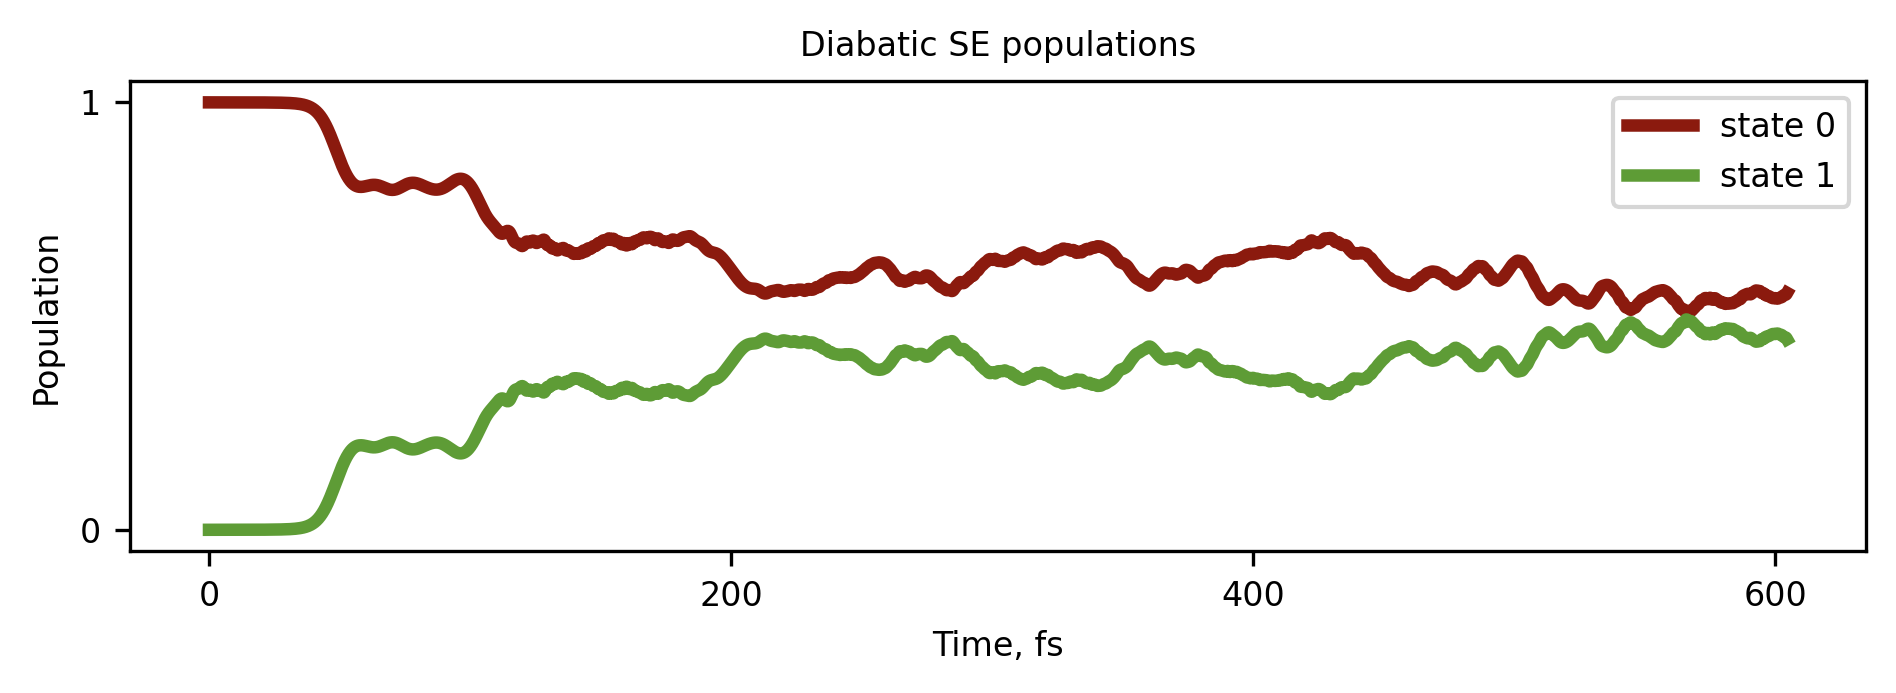

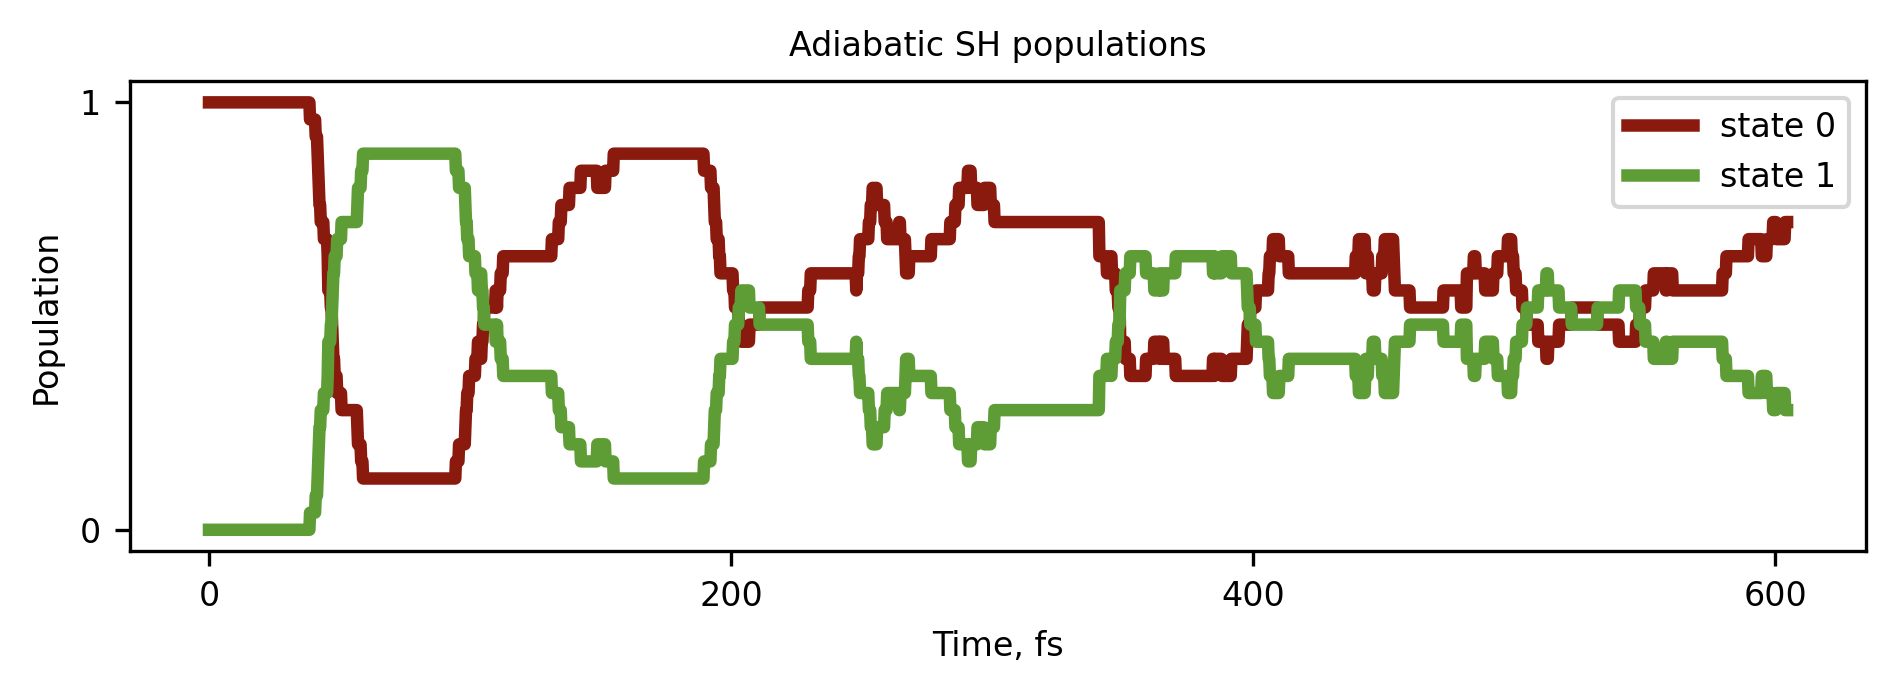

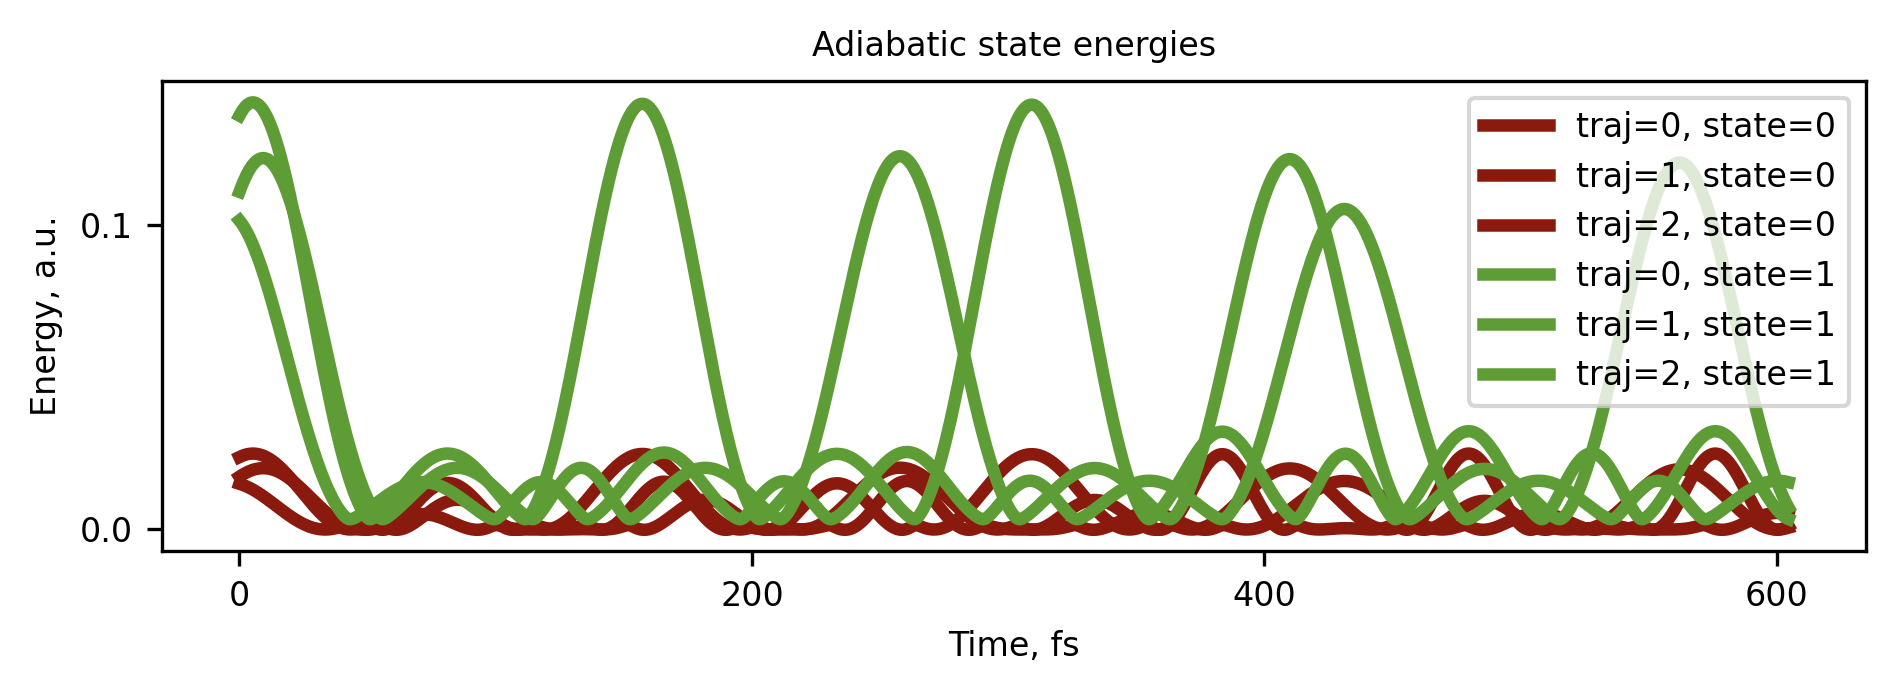

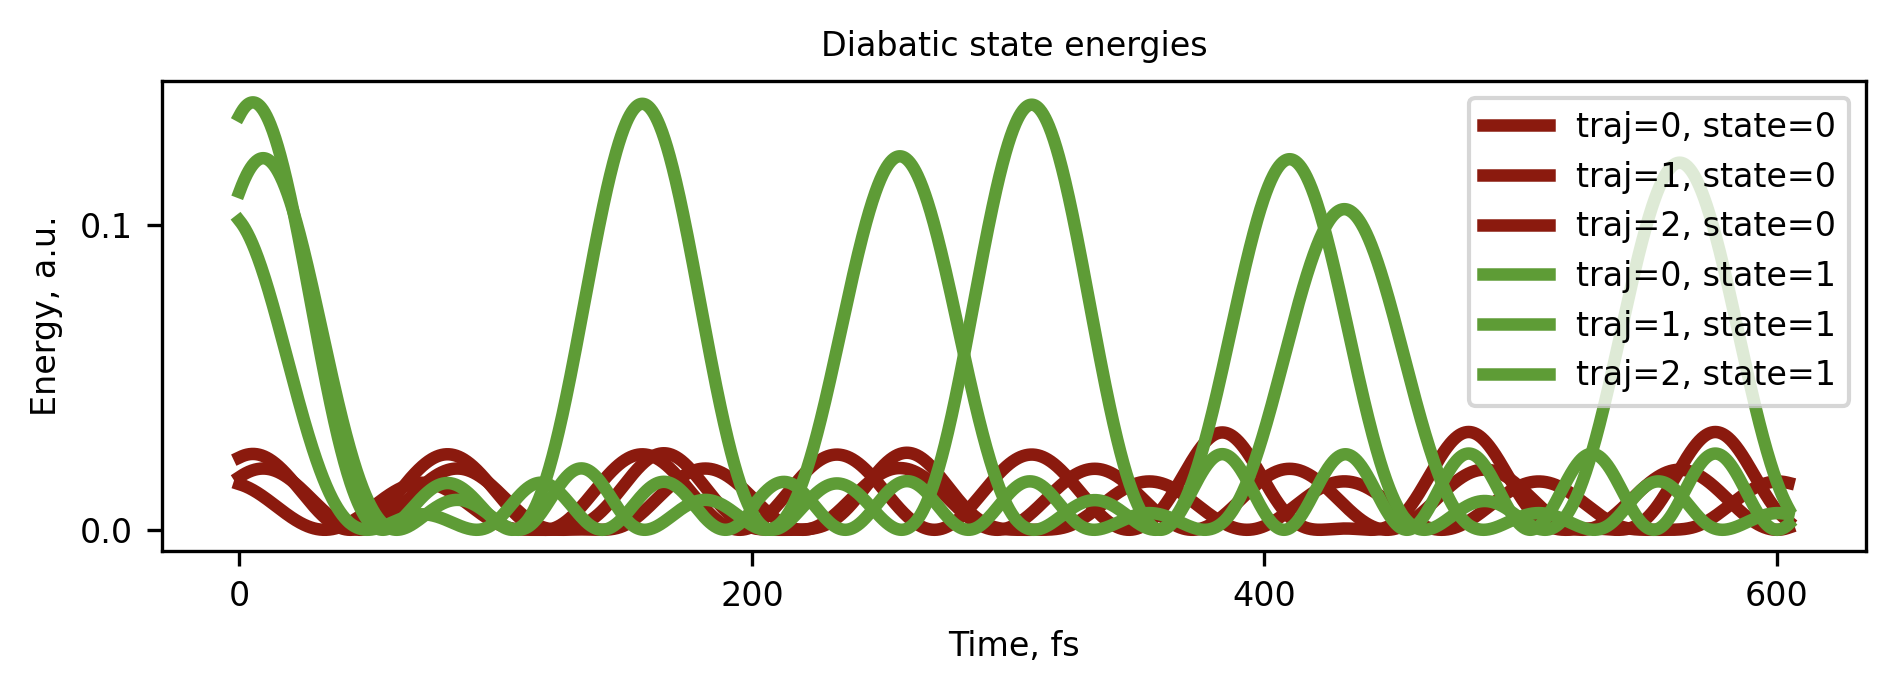

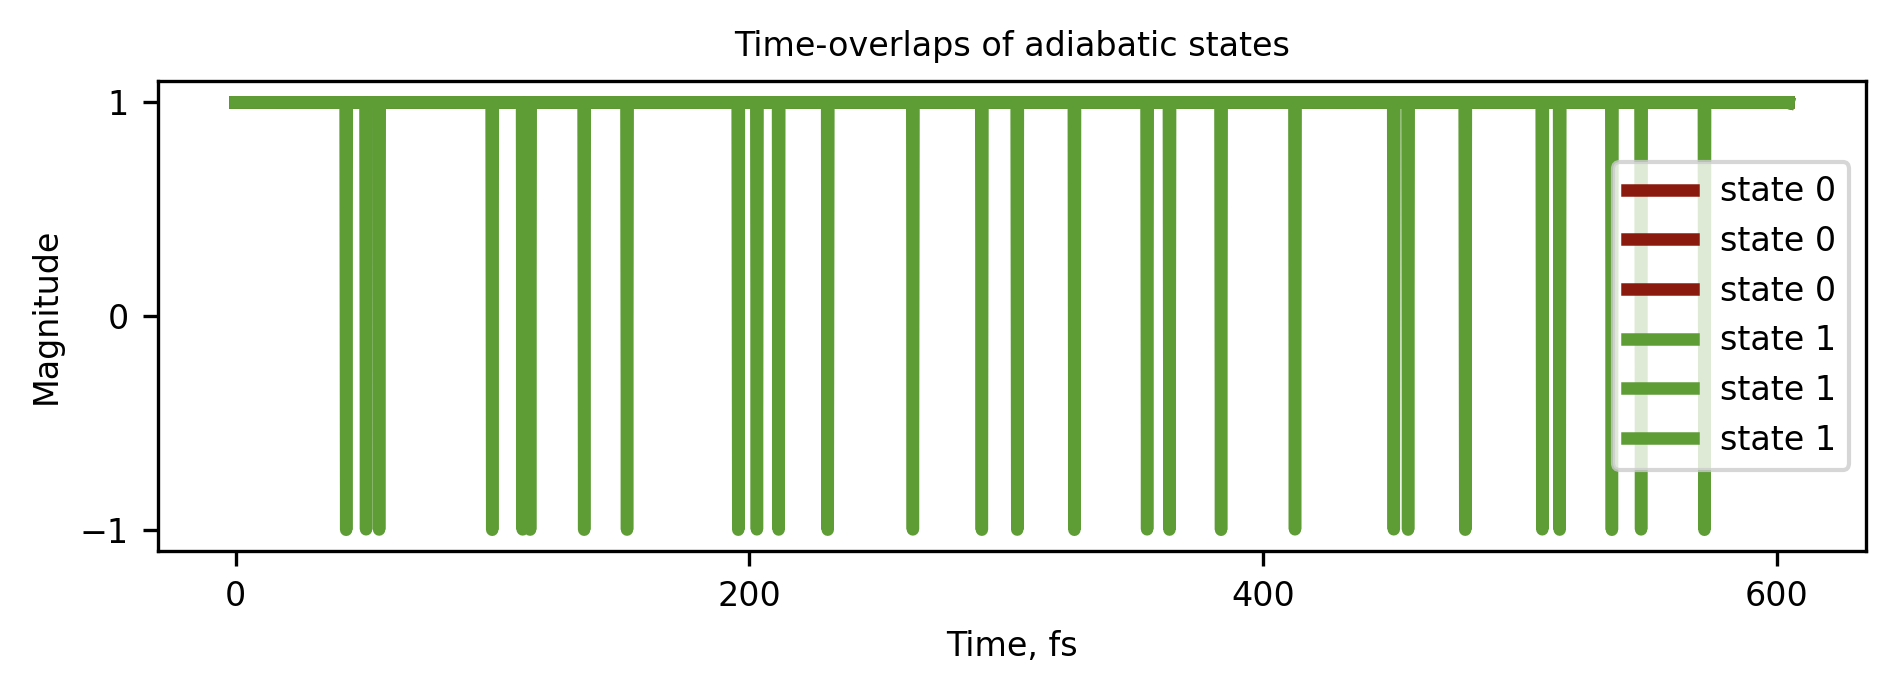

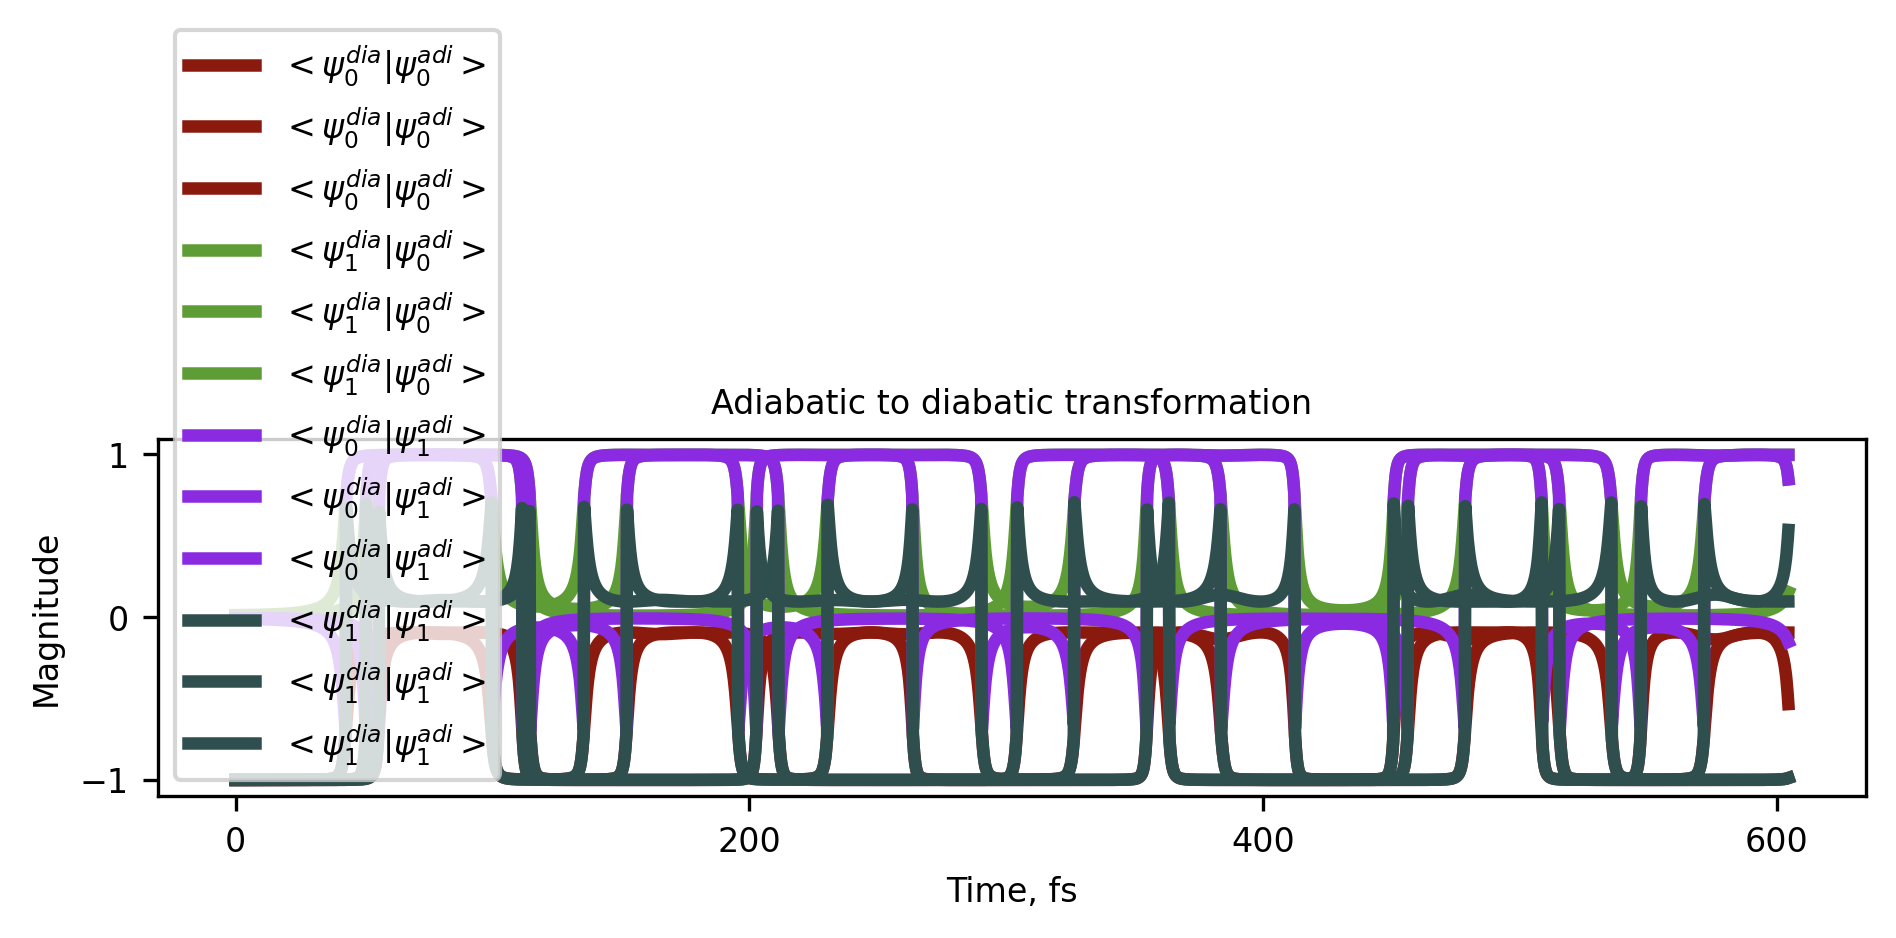

In [19]:
#============ Plotting ==================
#method_indx = 0
#model_indx = 1
#init_cond_indx = 6

pref = F"model{model_indx}-method{method_indx}-icond{icond_indx}"

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0, 1, 2], "which_dofs":[0], "which_adi_states":[0,1], "which_dia_states":[0,1], 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
                                "time_overlaps", "basis_transform"
                               ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

A more customizable way to plot some results quickly

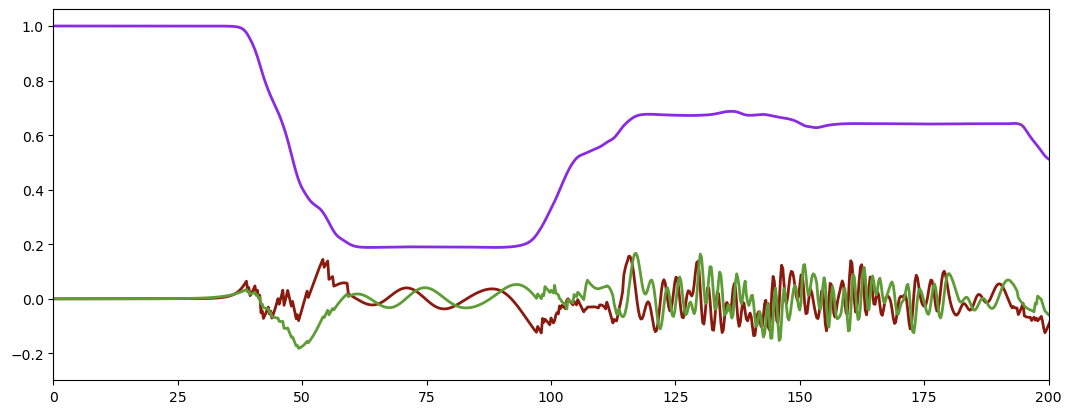

In [3]:
model_indx = 1
method_indx = 0
icond_indx = 15

pref = F"model{model_indx}-method{method_indx}-icond{icond_indx}"

plt.figure(figsize=(2*6.42, 2*2.41))
plt.xlim(0, 200)
with h5py.File(F"{pref}/mem_data.hdf", 'r') as f:        
    plt.plot(f["time/data"][:]/41.0, f["D_adi/data"][:, 0, 1].real, label="D01_adi", linewidth=2, color = colors["11"])
    plt.plot(f["time/data"][:]/41.0, f["D_adi/data"][:, 0, 1].imag, label="D01_adi", linewidth=2, color = colors["21"])
    plt.plot(f["time/data"][:]/41.0, f["D_adi/data"][:, 0, 0].real, label="D01_adi", linewidth=2, color = colors["31"])
    #plt.plot(f["time/data"][:]/41.0, f["D_adi/data"][:, 0, 1].imag, label="D01_adi", linewidth=2, color = colors["21"])
    

## 7. The corresponding SOFT calculations
<a name="7"></a>[Back to TOC](#TOC)
<a name="init_wfc-1"></a><a name="init_tsh_savers-1"></a><a name="run_dynamics-1"></a>

In [22]:
exact_params = { "nsteps":2500, "dt":10.0, "progress_frequency":1.0/2500,
                 "rmin":[-15.0], "rmax":[15.0], "dx":[0.025], "nstates":2,
                  "x0":[-4.0], "p0":[0.0], "istate":[1,0], "masses":[2000.0], "k":[0.01],
                  "integrator":"SOFT",
                  "mem_output_level":0, "txt_output_level":0, "txt2_output_level":0, "hdf5_output_level":2, 
                  "properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                                         "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                                         "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi" ],
                  "prefix":"exact", "prefix2":"exact", "use_compression":0, "compression_level":[0, 0, 0]
               }

wfc = dvr.init_wfc(exact_params, potential, model_params)
savers = dvr_save.init_tsh_savers(exact_params, model_params, exact_params["nsteps"], wfc)
dvr.run_dynamics(wfc, exact_params, model_params, savers)


ING: Parameter ylim is not defined! in the input parametersUse the default value 
Dimension 0 has 2048 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -20.000000
Lower wavevectors are computed 
nstates = 2
ndof = 1
Dimension 0 has 2048 grid points
Norm (dia) =  1.0
Norm (adi) =  1.0
Ekin (dia) =  0.0005590194337348286
Ekin (adi) =  0.0005590169943749468
Epot (dia) =  0.016100574010039066
Epot (adi) =  0.01610057401003907
HDF5 saver is initialized...
the datasets that can be saved are: ['timestep', 'time', 'Epot_dia', 'Ekin_dia', 'Etot_dia', 'Epot_adi', 'Ekin_adi', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']
 step= 0
 step= 1
 step= 2
 step= 3
 step= 4
 step= 5
 step= 6
 step= 7
 step= 8
 step= 9
 step= 10
 step= 11
 step= 12
 step= 13
 step= 14
 step= 15
 step= 16
 step= 17
 step= 18
 step= 19
 step= 20
 step= 21
 step= 22
 step= 23
 step= 24
 step= 25
 step= 26
 step= 27
 step= 28
 step= 29
 step= 30
 step= 

 step= 684
 step= 685
 step= 686
 step= 687
 step= 688
 step= 689
 step= 690
 step= 691
 step= 692
 step= 693
 step= 694
 step= 695
 step= 696
 step= 697
 step= 698
 step= 699
 step= 700
 step= 701
 step= 702
 step= 703
 step= 704
 step= 705
 step= 706
 step= 707
 step= 708
 step= 709
 step= 710
 step= 711
 step= 712
 step= 713
 step= 714
 step= 715
 step= 716
 step= 717
 step= 718
 step= 719
 step= 720
 step= 721
 step= 722
 step= 723
 step= 724
 step= 725
 step= 726
 step= 727
 step= 728
 step= 729
 step= 730
 step= 731
 step= 732
 step= 733
 step= 734
 step= 735
 step= 736
 step= 737
 step= 738
 step= 739
 step= 740
 step= 741
 step= 742
 step= 743
 step= 744
 step= 745
 step= 746
 step= 747
 step= 748
 step= 749
 step= 750
 step= 751
 step= 752
 step= 753
 step= 754
 step= 755
 step= 756
 step= 757
 step= 758
 step= 759
 step= 760
 step= 761
 step= 762
 step= 763
 step= 764
 step= 765
 step= 766
 step= 767
 step= 768
 step= 769
 step= 770
 step= 771
 step= 772
 step= 773
 step= 774

 step= 1395
 step= 1396
 step= 1397
 step= 1398
 step= 1399
 step= 1400
 step= 1401
 step= 1402
 step= 1403
 step= 1404
 step= 1405
 step= 1406
 step= 1407
 step= 1408
 step= 1409
 step= 1410
 step= 1411
 step= 1412
 step= 1413
 step= 1414
 step= 1415
 step= 1416
 step= 1417
 step= 1418
 step= 1419
 step= 1420
 step= 1421
 step= 1422
 step= 1423
 step= 1424
 step= 1425
 step= 1426
 step= 1427
 step= 1428
 step= 1429
 step= 1430
 step= 1431
 step= 1432
 step= 1433
 step= 1434
 step= 1435
 step= 1436
 step= 1437
 step= 1438
 step= 1439
 step= 1440
 step= 1441
 step= 1442
 step= 1443
 step= 1444
 step= 1445
 step= 1446
 step= 1447
 step= 1448
 step= 1449
 step= 1450
 step= 1451
 step= 1452
 step= 1453
 step= 1454
 step= 1455
 step= 1456
 step= 1457
 step= 1458
 step= 1459
 step= 1460
 step= 1461
 step= 1462
 step= 1463
 step= 1464
 step= 1465
 step= 1466
 step= 1467
 step= 1468
 step= 1469
 step= 1470
 step= 1471
 step= 1472
 step= 1473
 step= 1474
 step= 1475
 step= 1476
 step= 1477
 ste

 step= 2078
 step= 2079
 step= 2080
 step= 2081
 step= 2082
 step= 2083
 step= 2084
 step= 2085
 step= 2086
 step= 2087
 step= 2088
 step= 2089
 step= 2090
 step= 2091
 step= 2092
 step= 2093
 step= 2094
 step= 2095
 step= 2096
 step= 2097
 step= 2098
 step= 2099
 step= 2100
 step= 2101
 step= 2102
 step= 2103
 step= 2104
 step= 2105
 step= 2106
 step= 2107
 step= 2108
 step= 2109
 step= 2110
 step= 2111
 step= 2112
 step= 2113
 step= 2114
 step= 2115
 step= 2116
 step= 2117
 step= 2118
 step= 2119
 step= 2120
 step= 2121
 step= 2122
 step= 2123
 step= 2124
 step= 2125
 step= 2126
 step= 2127
 step= 2128
 step= 2129
 step= 2130
 step= 2131
 step= 2132
 step= 2133
 step= 2134
 step= 2135
 step= 2136
 step= 2137
 step= 2138
 step= 2139
 step= 2140
 step= 2141
 step= 2142
 step= 2143
 step= 2144
 step= 2145
 step= 2146
 step= 2147
 step= 2148
 step= 2149
 step= 2150
 step= 2151
 step= 2152
 step= 2153
 step= 2154
 step= 2155
 step= 2156
 step= 2157
 step= 2158
 step= 2159
 step= 2160
 ste

Now plot various properties

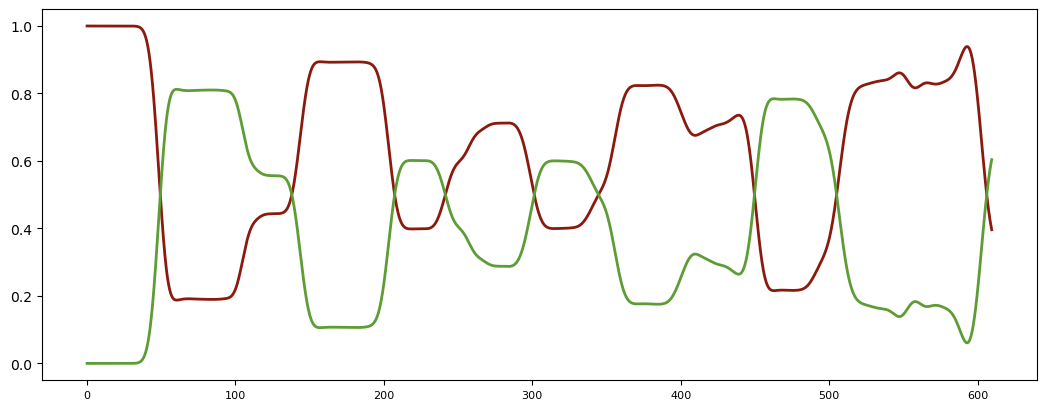

In [4]:
plt.figure(figsize=(2*6.42, 2*2.41))
plt.xticks(fontsize=8)
with h5py.File(F"exact/data.hdf", 'r') as f:        
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 0, 0], label="P0_adi", linewidth=2, color = colors["11"])
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 1, 0], label="P1_adi", linewidth=2, color = colors["21"])
    

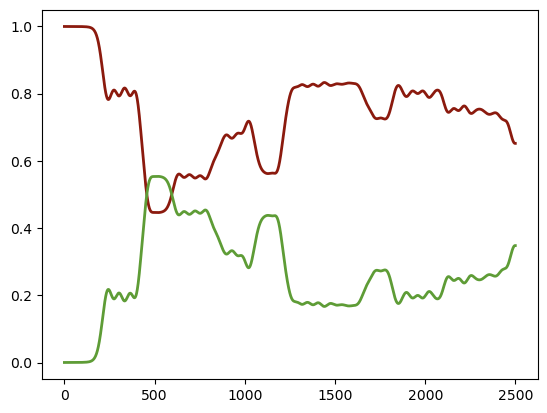

In [5]:
with h5py.File(F"exact/data.hdf", 'r') as f:        
    plt.plot(f["timestep/data"][:], f["pop_dia/data"][:, 0, 0], label="P0_adi", linewidth=2, color = colors["11"])
    plt.plot(f["timestep/data"][:], f["pop_dia/data"][:, 1, 0], label="P1_adi", linewidth=2, color = colors["21"])
    

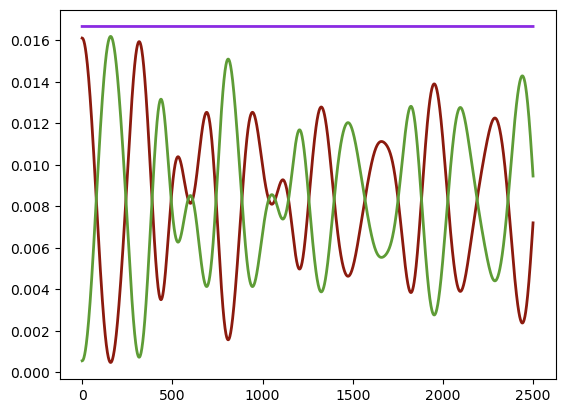

In [6]:
with h5py.File(F"exact/data.hdf", 'r') as f:        
    plt.plot(f["timestep/data"][:], f["Epot_dia/data"][:], label="E_pot", linewidth=2, color = colors["11"])
    plt.plot(f["timestep/data"][:], f["Ekin_dia/data"][:], label="E_kin", linewidth=2, color = colors["21"])
    plt.plot(f["timestep/data"][:], f["Etot_dia/data"][:], label="E_tot", linewidth=2, color = colors["31"])
    